# A4 Classification of Hand-Drawn Digits

* A4.1: *Now includes `optimizers.py`*
* A4.2: *Added `A4grader.zip` and extra credit.*

In this assignment, you will define a new class named `NeuralNetworkClassifier` that extends the `NeuralNetwork` class provided here and is the solution to Assignment A2.  You will use `NeuralNetworkClassifier` to train a classifier of hand-drawn digits.

You will also define the function `confusion_matrix`.

## `NeuralNetwork` class

In [1]:
import matplotlib.pyplot as plt

The following code cell will write its contents to `optimizers.py` so the `import optimizers` statement in the code cell after it will work correctly.

In [2]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):


        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Overwriting optimizers.py


In [3]:
import numpy as np
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'
    '''
    take out activation func
    '''

    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self
    '''
    so heres where activation func and grad replace relu and grad relu

    '''
    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
        '''
        replace self.relu and self.tanh with self.activation_function
        '''
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            '''
            replace if and else with this
            delta = delta @ self.Ws[layeri][1:, :].T * activation_function_gradient(self.Ys[layeri])
            '''            
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]#apply softmax to these values
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

Adam: Epoch 25 Error=0.24367
Adam: Epoch 50 Error=0.21188
Adam: Epoch 75 Error=0.15579
Adam: Epoch 100 Error=0.10126
Adam: Epoch 125 Error=0.08061
Adam: Epoch 150 Error=0.07021
Adam: Epoch 175 Error=0.06236
Adam: Epoch 200 Error=0.05577
Adam: Epoch 225 Error=0.05012
Adam: Epoch 250 Error=0.04526


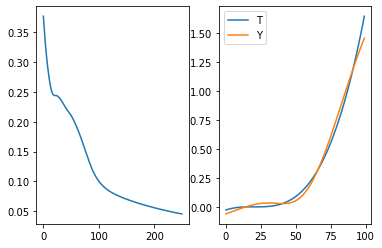

In [4]:
X = np.arange(100).reshape((-1, 1))
T = (X - 20) ** 3 / 300000

hiddens = [10]
nnet = NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, 250, 0.01, method='adam')

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

plt.subplot(1, 2, 2)
plt.plot(T, label='T')
plt.plot(nnet.use(X), label='Y')
plt.legend()

## Your `NeuralNetworkClassifier` class

Complete the following definition of `NeuralNetworkClassifier` as discussed in class. You will need to override the functions

* `train`
* `error_f`
* `gradient_f`
* `use`

and define the following new functions

* `makeIndicatorVars`
* `softmax`

In [5]:
'''
the constructor for this class should be found in NeuralNetwork
use super to call parent constructor if youre adding member variables to childclass

look at ex from notes of subclass for different act func
different train, objective,gradient,use function
easier to redefine whole train func here bc we dont want to unstandardize the targets and our origional train did
if you pull ut pieces of train from nn class and pull out pieces that would be changed in this new class then you
just have to override the pieces

grad/error: labeling the classes: indicator variables - softmax output   vs orig target variables

use must return two things, the class labels and the class probabilities

train(self, X, makeIndicatorVars(T), error_f)
power of e gives 0 or 1's which is likelihood
softmax and argmax for predictions

choosing btwn at 1:06:00 3/5
LDA QDA or llr you would look at their accuracies averaged over all ways of partitioning data over valid set
'''

class NeuralNetworkClassifier(NeuralNetwork):
    
    def makeIndicatorVars(self, T):#making the matrix of indicator variable to identify classes
        # Make sure T is two-dimensional. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)
    
   #forward pass
    def softmax(self, Y):#recieves Y's of last layer. Post process step
        fs = np.exp(Y)#fitting our model to a bunch of samples, our likelihood  
        denom = np.sum(fs, axis=1).reshape((-1, 1))
        gs = fs / denom
        return gs
    
    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X and NOT T
        X = (X - self.Xmeans) / self.Xstds
        
        self.classes=np.unique(T)
        
        T = self.makeIndicatorVars(T)

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)
        #comes from error_f output
        def error_convert_f(err):#want to convert this to likelihood neg_log_likelihood
            return np.exp(-err)#negate to maximize likelihood   
            
        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':
            #fargs needs to be indicator variable T not the origional T
            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self
    
        # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):#neg log likelihood
        Ys = self.forward_pass(X)
        probs = self.softmax(Ys[-1]) #change made for NeuralNetworkClassifier
        LL = T * np.log(probs + sys.float_info.epsilon) #change made for NeuralNetworkClassifier
        neg_mean_LL = -np.mean(LL) #change made for NeuralNetworkClassifier
        return neg_mean_LL #change made for NeuralNetworkClassifier
    

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):#T should be indicat
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        #derivative of the neg_log_likelihood
        error = -(T - self.softmax(self.Ys[-1]))#modify this, we want the indicator variable - probabilities. call softmax on output layers outputs
        #also negating the error because we want to maximize it probability. rest of back propagation is the same
        #but just using a different error
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta =  error / (n_samples * n_outputs)
        #delta = (error) / (TtrainI.shape[0] * TtrainI.shape[1])
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    
    #return and array of predicted classes and the class probabilities
    def use(self, X):
        Xs = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(Xs)
        Y = Ys[-1]
        probabilities = self.softmax(Y)#Apply softmax to the final layer after any call to forward_pass
        
        predictedClasses = self.classes[np.argmax(probabilities, axis=1)]
        predictedClasses = predictedClasses.reshape((-1, 1))
        
        print (predictedClasses.shape)
        print (probabilities.shape)
        
        return (predictedClasses, probabilities)
    
    

           
          


confusion matrix at 03:00 3/31

Here is a simple test of your new class.  For inputs from 0 to 100, classify values less than or equal to 25 as Class Label 25, greater than 25 and less than or equal to 75 as Class Label 75, and greater than 75 as Class Label 100. 

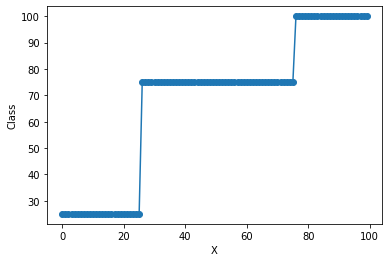

In [6]:
X = np.arange(100).reshape((-1, 1))
T = X.copy()
T[T <= 25] = 25
T[np.logical_and(25 < T, T <= 75)] = 75
T[T > 75] = 100

plt.plot(X, T, 'o-')
plt.xlabel('X')
plt.ylabel('Class');

Adam: Epoch 20 Error=0.79278
Adam: Epoch 40 Error=0.86506
Adam: Epoch 60 Error=0.90945
Adam: Epoch 80 Error=0.93503
Adam: Epoch 100 Error=0.95004
Adam: Epoch 120 Error=0.95902
Adam: Epoch 140 Error=0.96487
Adam: Epoch 160 Error=0.96902
Adam: Epoch 180 Error=0.97214
Adam: Epoch 200 Error=0.97459
(100, 1)
(100, 3)


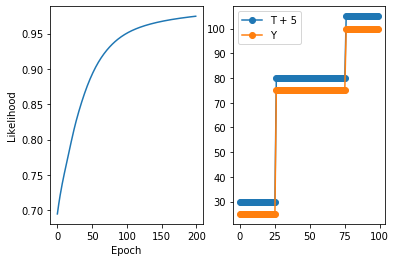

In [7]:
'''
we want to maximize the probability of the data, max likleyhood is 1-correct exactly fitting the training data
and the correct class is being produced for every sample
'''
hiddens = [10]
nnet = NeuralNetworkClassifier(X.shape[1], hiddens, len(np.unique(T)))
nnet.train(X, T, 200, 0.01, method='adam', verbose=True)

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T + 5, 'o-', label='T + 5')  # to see, when predicted overlap T very closely
plt.plot(nnet.use(X)[0], 'o-', label='Y')
plt.legend()

## Now for the Hand-Draw Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [8]:
'''
notes from 3/10 at 35:00

before just took a sqrt of the rmse to get error in origional units, now negate error 
and raise to power of e to get the actual likelihood instead of nnl
'''


import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]#input images
Ttrain = train_set[1].reshape(-1, 1)#classes

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [9]:
Ttrain[:10]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]], dtype=int64)

Those must be the digits.  What the heck is in those 784 columns in the input matrices?

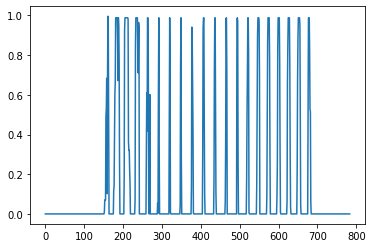

In [10]:
plt.plot(Xtrain[0, :]);#plot of first sample

Well, values between 0 and 1.  That doesn't help much.  These are actually intensity values for 784 pixels in an image.

How can we rearrange these values into an image to be displayed?  We must first figure out how many columns and rows the image would have.  Perhaps the image is a square image, with equal numbers of rows and columns.

In [11]:
import math
math.sqrt(784)

28.0

Ah, cool.

In [12]:
28 * 28

784

Ok Let's reshape it and look at the numbers.

In [13]:
image0 = Xtrain[0, :]
image0 = image0.reshape(28, 28)
image0

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

Not that helpful.  Ok, let's use `matplotlib` to make an image display.

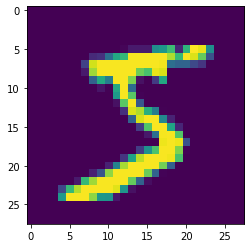

In [14]:
plt.imshow(image0);

Humm.  Try a grayscale color map.

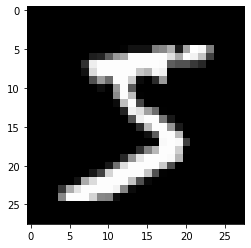

In [15]:
plt.imshow(image0, cmap='gray');

With a little more work, we can make it look like a pencil drawing.

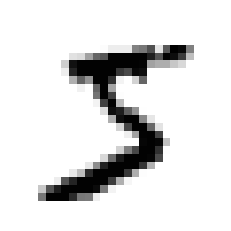

In [16]:
plt.imshow(-image0, cmap='gray')  # notice the negative sign
plt.axis('off');

Looks like a 5.  What class label is associated with this image?

In [17]:
Ttrain[0]

array([5], dtype=int64)

Okay.  Makes sense.  Let's look at the first 100 images and their labels, as plot titles.

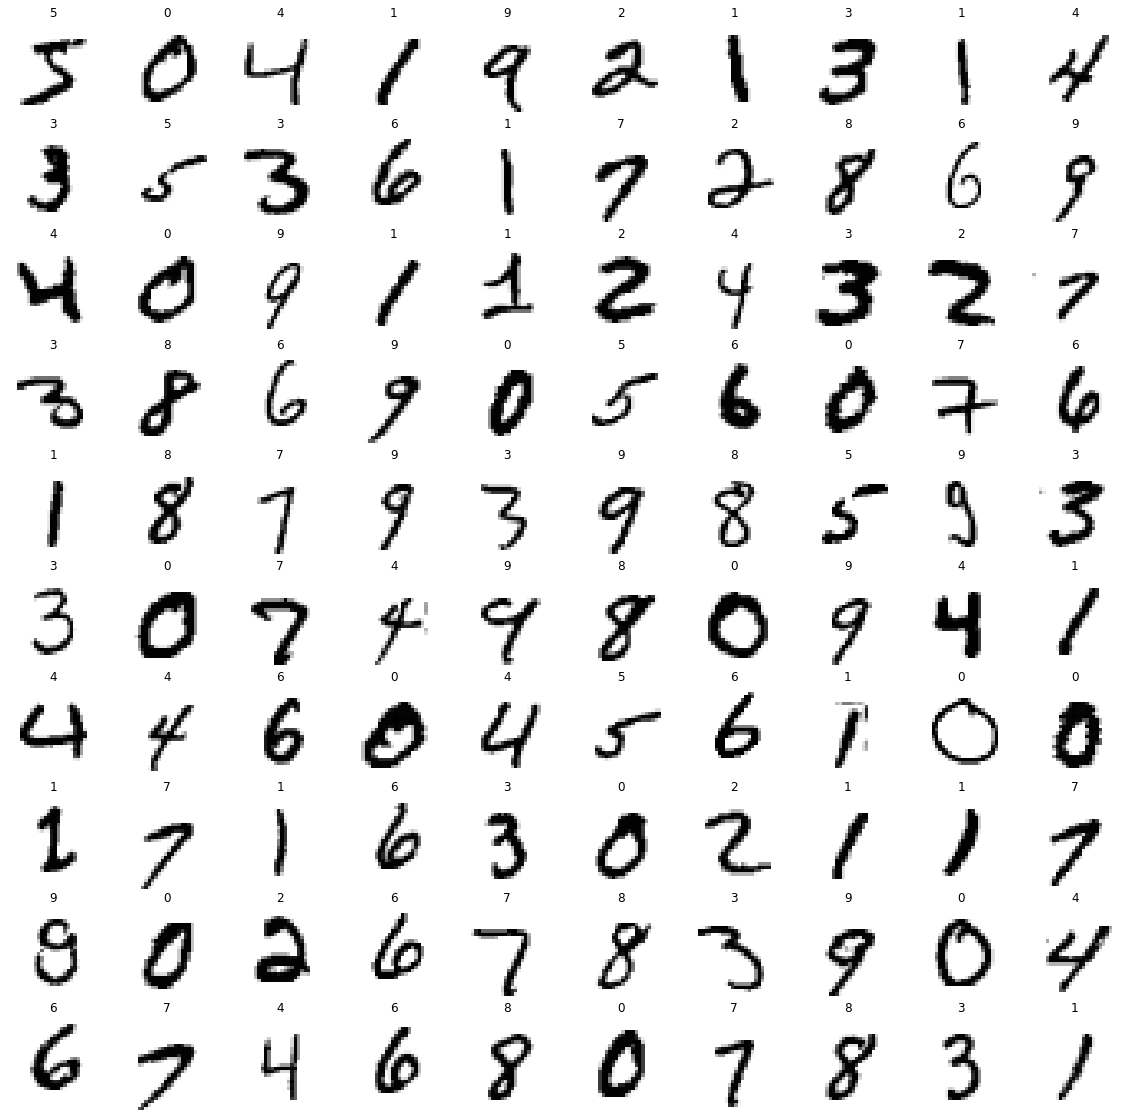

In [18]:
plt.figure(figsize=(20, 20))
for i in range(100):#first 100 sams
    plt.subplot(10, 10, i + 1)#draw the image in the ith row
    plt.imshow(-Xtrain[i, :].reshape(28, 28), cmap='gray')#reshape and negate it
    plt.title(Ttrain[i, 0])#make title of each image be the target label the digit
    plt.axis('off');

Okay.  We are ready to try to classify, right?

First we should check the proportions of each digit in the given data partitions.

In [19]:
classes = np.arange(10)
(Ttrain == classes).shape
#10 values for each sample. Train has to be a 2d for it to work

(50000, 10)

In [20]:
(Ttrain == classes).sum(axis=0)#sum accross rows, will find out many values in t train equal each closs

array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988])

In [21]:
(Ttrain == classes).sum(axis=0) / Ttrain.shape[0] #will find out many values in t train equal each closs

array([0.09864, 0.11356, 0.09936, 0.10202, 0.09718, 0.09012, 0.09902,
       0.1035 , 0.09684, 0.09976])

In [22]:
['Ttrain', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]]

['Ttrain',
 0.09864,
 0.11356,
 0.09936,
 0.10202,
 0.09718,
 0.09012,
 0.09902,
 0.1035,
 0.09684,
 0.09976]

In [23]:
import pandas

result = []
result.append(['Train', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]])
result.append(['Tval', *(Tval == classes).sum(axis=0) / Tval.shape[0]])
result.append(['Ttest', *(Ttest == classes).sum(axis=0) / Ttest.shape[0]])
pandas.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10
0,Train,0.09864,0.11356,0.09936,0.10202,0.09718,0.09012,0.09902,0.1035,0.09684,0.09976
1,Tval,0.09910,0.10640,0.09900,0.10300,0.09830,0.09150,0.09670,0.1090,0.10090,0.09610
2,Ttest,0.09800,0.11350,0.10320,0.10100,0.09820,0.08920,0.09580,0.1028,0.09740,0.10090


All very close to 0.1. Super.

Time for our first experiment.  Let's train a small neural net with 5 hidden units in one layer for a small number of epochs using Adam.

In [24]:
#from NeuralNetworks import *

In [25]:
n_epochs = 100
learning_rate = 0.01

np.random.seed(142)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Adam: Epoch 10 Error=0.82887
Adam: Epoch 20 Error=0.85170
Adam: Epoch 30 Error=0.87229
Adam: Epoch 40 Error=0.88913
Adam: Epoch 50 Error=0.90202
Adam: Epoch 60 Error=0.91179
Adam: Epoch 70 Error=0.91932
Adam: Epoch 80 Error=0.92541
Adam: Epoch 90 Error=0.93041
Adam: Epoch 100 Error=0.93447


NeuralNetworkClassifier(784, [5], 10, 'tanh')

'''
if you had this neuralnetwork how would you determine how accurate it was
can make confusion matrix
import pandas
class_names = range(10)
Classes, Probs = nnet.use(Xtest)
table = []
for true_class in range(10):
    row = []
    for predicted_class in range(10):
        row.append(100 * np.mean(Classes[Ttest == true_class] == predicted_class))
        # row.append(f'{100 * np.mean(Classes[Ttrain == true_class] == predicted_class):0.1f}')
    table.append(row)
    
print(f'Test percent correct {np.mean(Classes == Ttest) * 100:.2f}') 

conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f} %")

82.95
3/12 at 1:14:00
'''

In [26]:
print(nnet)  # uses the __str__ method

NeuralNetworkClassifier(784, [5], 10, 'tanh') trained for 100 epochs, final training error 0.9345


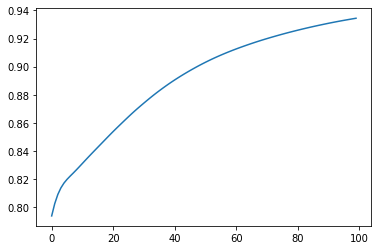

In [27]:
plt.plot(nnet.error_trace);

Now it is time for you to run some longer experiments.  You must write the code to do the following steps:

try to find values it does poorly on and see if it makes sense

1. For each of at least five different hidden layer structures

    1. Train a network for 500 epochs.
    1. Collect percent of samples correctly classified in the given train, validate, and test partitions.

2. Create a `pandas.DataFrame` with these results and with column headings `('Hidden Layers', 'Train', 'Validate', 'Test', 'Time')` where `'Time'` is the number of seconds required to train each network.

3. Retrain a network using the best hidden layer structure, judged by the percent correct on the validation set.
4. Use this network to find several images in the test set for which the network's probability of the correct class is the closest to zero, meaning images for which your network does the worst.  Draw these images and discuss why your network might not be doing well for those images.

In [28]:
import time
import pandas
import math
n_epochs = 50
learning_rate = .01
n_classes = len(np.unique(T))
names = ('Hidden Layers', 'Train', 'Validate', 'Test', 'Time')

hidden = []
train = []
validate = []
test = []
times = []
table = []

def matrix_1(Xtrain, Ttrain):
    start_time = time.time()
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)
    elapsed_time = time.time() - start_time
    times.append(round(elapsed_time,2))
    Classes, Probs = nnet.use(Xtrain)
    print(f'Train Percent correct {np.mean(Classes == Ttrain) * 100:.2f}')
    train.append(round((np.mean(Classes == Ttrain) * 100),2))

def matrix_2(Xval, Tval):
    nnet.train(Xval, Tval, n_epochs, learning_rate, method='adam', verbose=True)
    Classes, Probs = nnet.use(Xval)
    validate.append(round((np.mean(Classes == Tval) * 100),2))
    
def matrix_3(Xtest, Ttest):
    nnet.train(Xtest, Ttest, n_epochs, learning_rate, method='adam', verbose=True)
    Classes, Probs = nnet.use(Xtest)
    test.append(round((np.mean(Classes == Ttest) * 100),2))
    
nnet = NeuralNetworkClassifier(Xtrain.shape[1], [], len(classes))
hidden.append("[0]")
matrix_1(Xtrain, Ttrain)   
matrix_2(Xval, Tval)
matrix_3(Xtest, Ttest)
    
nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))
hidden.append("[5]")
matrix_1(Xtrain, Ttrain)   
matrix_2(Xval, Tval)
matrix_3(Xtest, Ttest)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5,5], len(classes))
hidden.append("[5,5]")
matrix_1(Xtrain, Ttrain)   
matrix_2(Xval, Tval)
matrix_3(Xtest, Ttest)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [10,10], len(classes))
hidden.append("[10,10]")
matrix_1(Xtrain, Ttrain)   
matrix_2(Xval, Tval)
matrix_3(Xtest, Ttest)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [10,10,10], len(classes))
hidden.append("[10,10,10]")
matrix_1(Xtrain, Ttrain)   
matrix_2(Xval, Tval)
matrix_3(Xtest, Ttest)

df = pandas.DataFrame({'Hidden Layers':hidden, 
                   'Train':train, 
                   'Validate':validate,
                   'Test':test,
                   'Times':times})
print(df)

classes = np.arange(10)
(Ttrain == classes).shape
['Ttrain', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]]

result = []
result.append(['Train', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]])
result.append(['Tval', *(Tval == classes).sum(axis=0) / Tval.shape[0]])
result.append(['Ttest', *(Ttest == classes).sum(axis=0) / Ttest.shape[0]])
pandas.DataFrame(result)

Adam: Epoch 5 Error=0.94650
Adam: Epoch 10 Error=0.95892
Adam: Epoch 15 Error=0.96255
Adam: Epoch 20 Error=0.96536
Adam: Epoch 25 Error=0.96746
Adam: Epoch 30 Error=0.96914
Adam: Epoch 35 Error=0.97047
Adam: Epoch 40 Error=0.97160
Adam: Epoch 45 Error=0.97253
Adam: Epoch 50 Error=0.97328
(50000, 1)
(50000, 10)
Train Percent correct 92.54
Adam: Epoch 5 Error=0.97762
Adam: Epoch 10 Error=0.98209
Adam: Epoch 15 Error=0.98483
Adam: Epoch 20 Error=0.98651
Adam: Epoch 25 Error=0.98779
Adam: Epoch 30 Error=0.98884
Adam: Epoch 35 Error=0.98970
Adam: Epoch 40 Error=0.99042
Adam: Epoch 45 Error=0.99104
Adam: Epoch 50 Error=0.99158
(10000, 1)
(10000, 10)
Adam: Epoch 5 Error=0.96487
Adam: Epoch 10 Error=0.97459
Adam: Epoch 15 Error=0.97960
Adam: Epoch 20 Error=0.98303
Adam: Epoch 25 Error=0.98602
Adam: Epoch 30 Error=0.98781
Adam: Epoch 35 Error=0.98933
Adam: Epoch 40 Error=0.99042
Adam: Epoch 45 Error=0.99124
Adam: Epoch 50 Error=0.99190
(10000, 1)
(10000, 10)
Adam: Epoch 5 Error=0.81574
Adam: Ep

,0,1,2,3,4,5,6,7,8,9,10
0,Train,0.09864,0.11356,0.09936,0.10202,0.09718,0.09012,0.09902,0.1035,0.09684,0.09976
1,Tval,0.09910,0.10640,0.09900,0.10300,0.09830,0.09150,0.09670,0.1090,0.10090,0.09610
2,Ttest,0.09800,0.11350,0.10320,0.10100,0.09820,0.08920,0.09580,0.1028,0.09740,0.10090


It is likely that my network performed badly on 5 and 8 because of how a 5 can look like a 3 and how 8 is not a very consistent style.

## `confusion_matrix`

Now, write a function named `confusion_matrix` that returns a confusion matrix for any classification problem, returned as a `pandas.DataFrame` as shown in Lecture Notes 12.  It must require two arguments, the predicted classes for each sample and the true classes for each sample.  Here is an example.

In [29]:
def confusion_matrix(Y_classes, T_data):#classes predicted by nn and the correct classes. guessed labels and actual labels
    class_names = np.unique(T_data)
    table = []
    for true_class in (class_names):#for each actual class range 1-10
        row = []
        for predicted_class in (class_names):#how many samples that were actually from that class correctly predicted
            row.append(100 * np.mean(Y_classes[T_data == true_class] == predicted_class))
            #pull out of our classes output of use all the rows for which the correct class is the true class
            #true for all the rows corre to samps for the correct is the true class
            #true and false mask selects particular classes we produced and see how often they equalled the particular predicted class
            # mean for fraction of ones that were correct. Taking the mean of 0's and 1's
        table.append(row)

    print(f'Test percent correct {np.mean(Y_classes == T_data) * 100:.2f}') 
    
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    #conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f} %")
    
    return conf_matrix

In [30]:
Y_classes, Y_probs = nnet.use(Xtest)
confusion_matrix(Y_classes, Ttest)

(10000, 1)
(10000, 10)
Test percent correct 93.93


,0,1,2,3,4,5,6,7,8,9
0,97.551020,0.000000,0.714286,0.000000,0.204082,0.102041,1.224490,0.102041,0.102041,0.000000
1,0.000000,98.325991,0.704846,0.352423,0.000000,0.264317,0.088106,0.088106,0.088106,0.088106
2,3.100775,0.484496,92.635659,1.162791,0.484496,0.290698,0.290698,0.678295,0.290698,0.581395
3,0.000000,0.396040,1.089109,95.643564,0.000000,1.287129,0.000000,0.594059,0.396040,0.594059
4,0.000000,0.000000,0.101833,0.203666,95.112016,0.305499,1.221996,0.509165,0.407332,2.138493
5,0.336323,0.112108,0.448430,2.242152,0.784753,89.349776,0.784753,0.000000,5.605381,0.336323
6,1.043841,0.000000,0.417537,0.000000,0.417537,1.983299,96.033403,0.000000,0.104384,0.000000
7,0.291829,1.070039,0.972763,0.583658,0.194553,0.000000,0.000000,95.233463,0.000000,1.653696
8,0.102669,0.000000,0.000000,1.848049,0.616016,9.753593,1.026694,0.000000,85.934292,0.718686
9,0.099108,0.198216,0.198216,0.991080,2.874133,0.099108,0.297324,1.585728,1.288404,92.368682


## Grading and Check-In
Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A4grader.zip) and extract A4grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A4.ipynb.  

When ready, submit your notebook via the A4 link in our class Canvas web page.

In [31]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A4.2 Classification of Hand-Drawn Digits.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.forward_pass.__func__ == nn_class.forward_pass.__func__


--- 10/10 points.  Function NeuralNetwork.forward_pass is correctly not overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.train.__func__ != nn_class.train.__func__


--- 10/10 points.  Function NeuralNetwork.train is correctly overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.use.__func__ != nn_class.use.__func__


--- 10/10 points.  Function NeuralNetwork.use i

## Extra Credit
Earn 1 extra credit point on this assignment by doing the following.

1. Combine the train, validate, and test partitions loaded from the MNIST data file into two matrices, `X` and `T`. 
2. Using `adam` , `relu` and just one value of `learning_rate` and `n_epochs`, compare several hidden layer architectures. Do so by applying our `generate_k_fold_cross_validation_sets` function as defined in Lecture Notes 12 which forms stratified partitioning, for use in classification problems, to your `X` and `T` matrices using `n_fold` of 3.
3. Show results and discuss which architectures you find works the best, and how you determined this.